In [126]:
import pandas as pd
from linearmodels import PanelOLS
import numpy as np

def prepare_data():
    """Prepare data for regression analysis"""
    filepath = r'at.dta'
    df = pd.read_stata(filepath)
    df = df.set_index(['app_num', 'ym'])
    df['AFTER_BAN'] = (df.index.get_level_values('ym') >= 716).astype(int)
    df['TREATXAFTER_BAN'] = df['ann_TREAT'] * df['AFTER_BAN']
    return df

def generate_summary_statistics(data):
    """Generate summary statistics for main variables"""
    variables = ['Rating', 'Log_Demand', 'Age', 'Price',
                 'Log_Firm_Size', 'One_Employee']
    
    summary_stats = data[variables].agg(['mean', 'std', 'min', 'median', 'max']).T
    summary_stats.columns = ['Mean', 'Std Dev', 'Min', 'Median', 'Max']
    
    return summary_stats

def run_panel_ols(data, model_type='full'):
    """Run panel OLS regression"""
    Y = data['Rating']
    
    if model_type == 'simple':
        X = data[['TREATXAFTER_BAN', 'genre_cons']]
    else:  # full model
        X = data[['TREATXAFTER_BAN', 'genre_cons', 'Log_Demand', 
                  'Price', 'Log_Firm_Size', 'One_Employee', 'Age']]
    
    model = PanelOLS(Y, X, entity_effects=True, time_effects=True)
    results = model.fit(cov_type='clustered', cluster_entity=True)
    
    # Print coefficients with higher precision
    print("\nPanel OLS Results:")
    print("=====================================================================================================")
    print(f"{'Parameter':<35} {'Coefficient':>15} {'Std. Err.':>15} {'T-stat':>10} {'P-value':>10} {'Lower CI':>10} {'Upper CI':>10}")
    print("-----------------------------------------------------------------------------------------------------")
    for param, coef, std_err, t_stat, p_val, ci_low, ci_up in zip(
        results.params.index, 
        results.params.values, 
        results.std_errors.values, 
        results.tstats.values, 
        results.pvalues.values, 
        results.conf_int().iloc[:, 0].values, 
        results.conf_int().iloc[:, 1].values
    ):
        print(f"{param:<35} {coef:>15.10f} {std_err:>15.10f} {t_stat:>10.4f} {p_val:>10.4f} {ci_low:>10.10f} {ci_up:>10.10f}")
    
    return results


def main():
    df = prepare_data()

    # Run summary statistics
    summary_stats = generate_summary_statistics(df)
    print("Summary Statistics:")
    print(summary_stats)
    
    # Run simple model
    simple_results = run_panel_ols(df, model_type='simple')
    print("\nSimple Model Results:")
    print(simple_results)
    
    # Run full model
    full_results = run_panel_ols(df, model_type='full')
    print("\nFull Model Results:")
    print(full_results)
    
    return summary_stats, simple_results, full_results, df

if __name__ == "__main__":
    summary_stats, simple_results, full_results, df = main()

Summary Statistics:
                     Mean     Std Dev       Min      Median          Max
Rating           4.061931    0.522589  1.000000    4.100000     5.000000
Log_Demand       6.308229    3.208901  0.000000    6.426488    15.716231
Age            696.624329  613.680298  1.000000  489.000000  3639.000000
Price            0.004623    0.067865  0.000000    0.000000     1.000000
Log_Firm_Size    2.554413    1.227991  0.693147    2.484907     7.239215
One_Employee     0.859508    0.347312  0.000000    1.000000     1.000000

Panel OLS Results:
Parameter                               Coefficient       Std. Err.     T-stat    P-value   Lower CI   Upper CI
-----------------------------------------------------------------------------------------------------
TREATXAFTER_BAN                        0.0273642880    0.0094115298     2.9075     0.0036 0.0089177744 0.0458108016
genre_cons.Adventure and Strategy     -0.0174946731    0.0384613433    -0.4549     0.6492 -0.0928785595 0.0578892132
ge

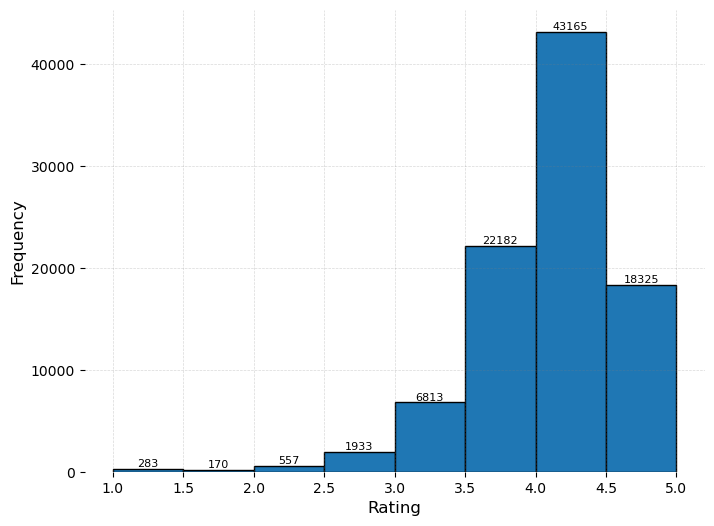

In [268]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(1, 5.5, 0.5)
plt.figure(figsize=(8, 6))

# Plot the histogram and save the patches for the bars
n, bins, patches = plt.hist(df['Rating'], bins=bins, color='#1f77b4', edgecolor='black', linewidth=1)

# Add value labels above each bar, centered over each bar
for patch in patches:
    # Get the bar's center
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2  # Center of the bar
    plt.text(x, height, str(int(height)), ha='center', va='bottom', fontsize=8)

plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(bins, fontsize=10)
plt.yticks(fontsize=10)

# Custom grid function to avoid lines passing through the bars
def custom_grid(ax, which='major'):
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()

    for x in xticks:
        if x >= xmin and x <= xmax:
            ax.axvline(x, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    for y in yticks:
        if y >= ymin and y <= ymax:
            ax.axhline(y, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

plt.grid(False)  # Turn off the default grid
custom_grid(plt.gca())
plt.box(on=None)

plt.savefig('distribution_of_game_ratings.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [290]:
import pandas as pd

df = prepare_data()

# Group by app_num and count the instances
app_counts = df.groupby('app_num').size()

# Calculate the average count
average_count = app_counts.mean()

print("Average count of app_num instances:", average_count)

Average count of app_num instances: 17.091875214261226


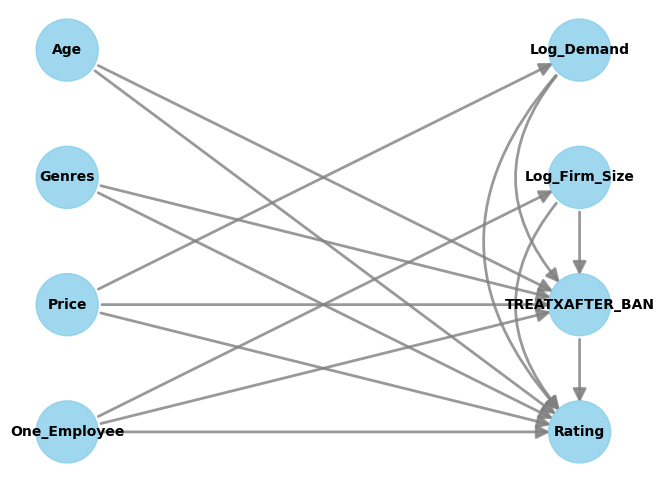

In [180]:
import warnings
from dowhy import CausalModel

# Suppress warnings for better clarity
warnings.filterwarnings("ignore")

# Define treatment and outcome variables
treatment = 'TREATXAFTER_BAN'
outcome = 'Rating'

# Prepare data
df = prepare_data()

# Define the causal model with a clear graph structure
model = CausalModel(
    data=df, 
    treatment=treatment, 
    outcome=outcome, 
    graph="""graph[directed 1
        node[id "Log_Demand" label "Log_Demand"]
        node[id "Age" label "Age"]
        node[id "genre_cons" label "Genres"]
        node[id "Price" label "Price"]
        node[id "One_Employee" label "One_Employee"]
        node[id "Log_Firm_Size" label "Log_Firm_Size"]
        node[id "TREATXAFTER_BAN" label "TREATXAFTER_BAN"]
        node[id "Rating" label "Rating"]
        
        edge[source "Log_Demand" target "TREATXAFTER_BAN"]
        edge[source "Age" target "TREATXAFTER_BAN"]
        edge[source "genre_cons" target "TREATXAFTER_BAN"]
        edge[source "Price" target "TREATXAFTER_BAN"]
        edge[source "One_Employee" target "TREATXAFTER_BAN"]
        edge[source "Log_Firm_Size" target "TREATXAFTER_BAN"]
        
        edge[source "Price" target "Log_Demand"]
        edge[source "One_Employee" target "Log_Firm_Size"]
        
        edge[source "Log_Demand" target "Rating"]
        edge[source "Age" target "Rating"]
        edge[source "genre_cons" target "Rating"]
        edge[source "Price" target "Rating"]
        edge[source "One_Employee" target "Rating"]
        edge[source "Log_Firm_Size" target "Rating"]
        edge[source "TREATXAFTER_BAN" target "Rating"]
    ]
    """
)

# Visualize the causal model
model.view_model()


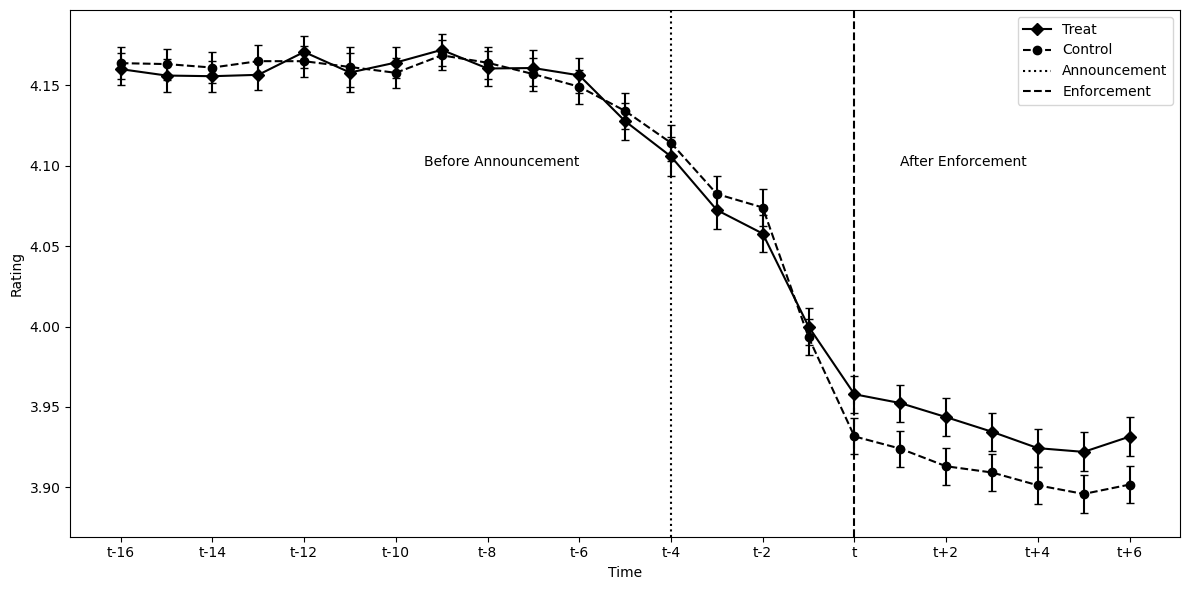

In [286]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = prepare_data()

# Calculate the mean Rating and standard error for each group over time
def calc_stats(group):
    return pd.Series({
        'mean': group['Rating'].mean(),
        'se': group['Rating'].sem()
    })

treat_stats = df[df['ann_TREAT'] == 1].groupby('ym').apply(calc_stats).reset_index()
control_stats = df[df['ann_TREAT'] == 0].groupby('ym').apply(calc_stats).reset_index()

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines
ax.plot(treat_stats['ym'], treat_stats['mean'], color='black', linestyle='solid', marker='D', label='Treat')
ax.plot(control_stats['ym'], control_stats['mean'], color='black', linestyle='dashed', marker='o', label='Control')

# Add error bars
ax.errorbar(treat_stats['ym'], treat_stats['mean'], yerr=treat_stats['se'], 
            fmt='none', ecolor='black', capsize=3)
ax.errorbar(control_stats['ym'], control_stats['mean'], yerr=control_stats['se'], 
            fmt='none', ecolor='black', capsize=3)

ax.set_xlabel('Time')
ax.set_ylabel('Rating')

# Adjust x-ticks to span the entire graph with 't' as the benchmark
min_ym = int(min(treat_stats['ym'].min(), control_stats['ym'].min()))
max_ym = int(max(treat_stats['ym'].max(), control_stats['ym'].max()))
benchmark_ym = 716

ym_range = list(range(min_ym, max_ym + 1, 2))  # Adjust step size if needed
labels = [f't{i - benchmark_ym:+d}' if i != benchmark_ym else 't' for i in ym_range]

ax.set_xticks(ym_range)
ax.set_xticklabels(labels)

ax.grid(False)
ax.axvline(712, color='black', linestyle='dotted', label='Announcement')
ax.axvline(716, color='black', linestyle='--', label='Enforcement')
ax.text(710, 4.1, 'Before Announcement', ha='right')
ax.text(717, 4.1, 'After Enforcement', ha='left')
ax.legend()

plt.tight_layout()
# Save as PNG
plt.savefig('fig_rating_did.png', format='png', dpi=300)  # Save as PNG with 300 dpi for better quality

In [9]:
import pandas as pd
import numpy as np

def analyze_treatment_control():
    # Calculate means for each time period and group
    treatment = df[df['ann_TREAT'] == 1].groupby('ym')['Rating'].mean()
    control = df[df['ann_TREAT'] == 0].groupby('ym')['Rating'].mean()
    
    # Create DataFrame with results
    results = pd.DataFrame({
        'Treatment': treatment,
        'Control': control
    })
    
    # Get the benchmark time period (t=0)
    benchmark_ym = 716  # Based on your plot code
    
    # Convert time periods to t-notation, handling float values
    def format_time(x):
        diff = int(x - benchmark_ym)  # Convert to int for formatting
        if diff == 0:
            return 't'
        else:
            return f't{diff:+d}'
    
    # The index is now the 'ym' column
    results['Time'] = results.index.map(format_time)
    
    # Calculate differences
    results['Difference'] = results['Treatment'] - results['Control']
    
    # Sort by the index (ym) and select columns in desired order
    results = results.sort_index()[['Time', 'Treatment', 'Control', 'Difference']]
    
    # Set display options for full precision
    pd.set_option('display.float_format', lambda x: '%.6f' % x)
    
    return results

# Run the analysis
results = analyze_treatment_control()

# Display results
print("\nDetailed Analysis with Exact Values:")
print(results)

# Calculate period-specific statistics
before_announcement = results[results.index < 712]['Difference'].mean()
after_enforcement = results[results.index >= 716]['Difference'].mean()

print("\nSummary Statistics:")
print(f"\nMean Difference Before Announcement: {before_announcement:.6f}")
print(f"Mean Difference After Enforcement: {after_enforcement:.6f}")


Detailed Analysis with Exact Values:
            Time  Treatment  Control  Difference
ym                                              
700.000000  t-16   4.160174 4.163901   -0.003727
701.000000  t-15   4.156185 4.163324   -0.007139
702.000000  t-14   4.155778 4.161156   -0.005377
703.000000  t-13   4.156637 4.165137   -0.008501
704.000000  t-12   4.170855 4.165113    0.005741
705.000000  t-11   4.158070 4.161517   -0.003447
706.000000  t-10   4.164281 4.157880    0.006402
707.000000   t-9   4.172170 4.168777    0.003393
708.000000   t-8   4.160572 4.164148   -0.003576
709.000000   t-7   4.160870 4.157076    0.003793
710.000000   t-6   4.156298 4.149216    0.007082
711.000000   t-5   4.127784 4.134161   -0.006377
712.000000   t-4   4.105831 4.114296   -0.008466
713.000000   t-3   4.072514 4.082495   -0.009981
714.000000   t-2   4.057867 4.074094   -0.016227
715.000000   t-1   4.000041 3.993344    0.006696
716.000000     t   3.957915 3.931684    0.026232
717.000000   t+1   3.952434 3.9

Preparing data...

Running Regression Tree Analysis:
Mean Squared Error: 0.23438457683927016


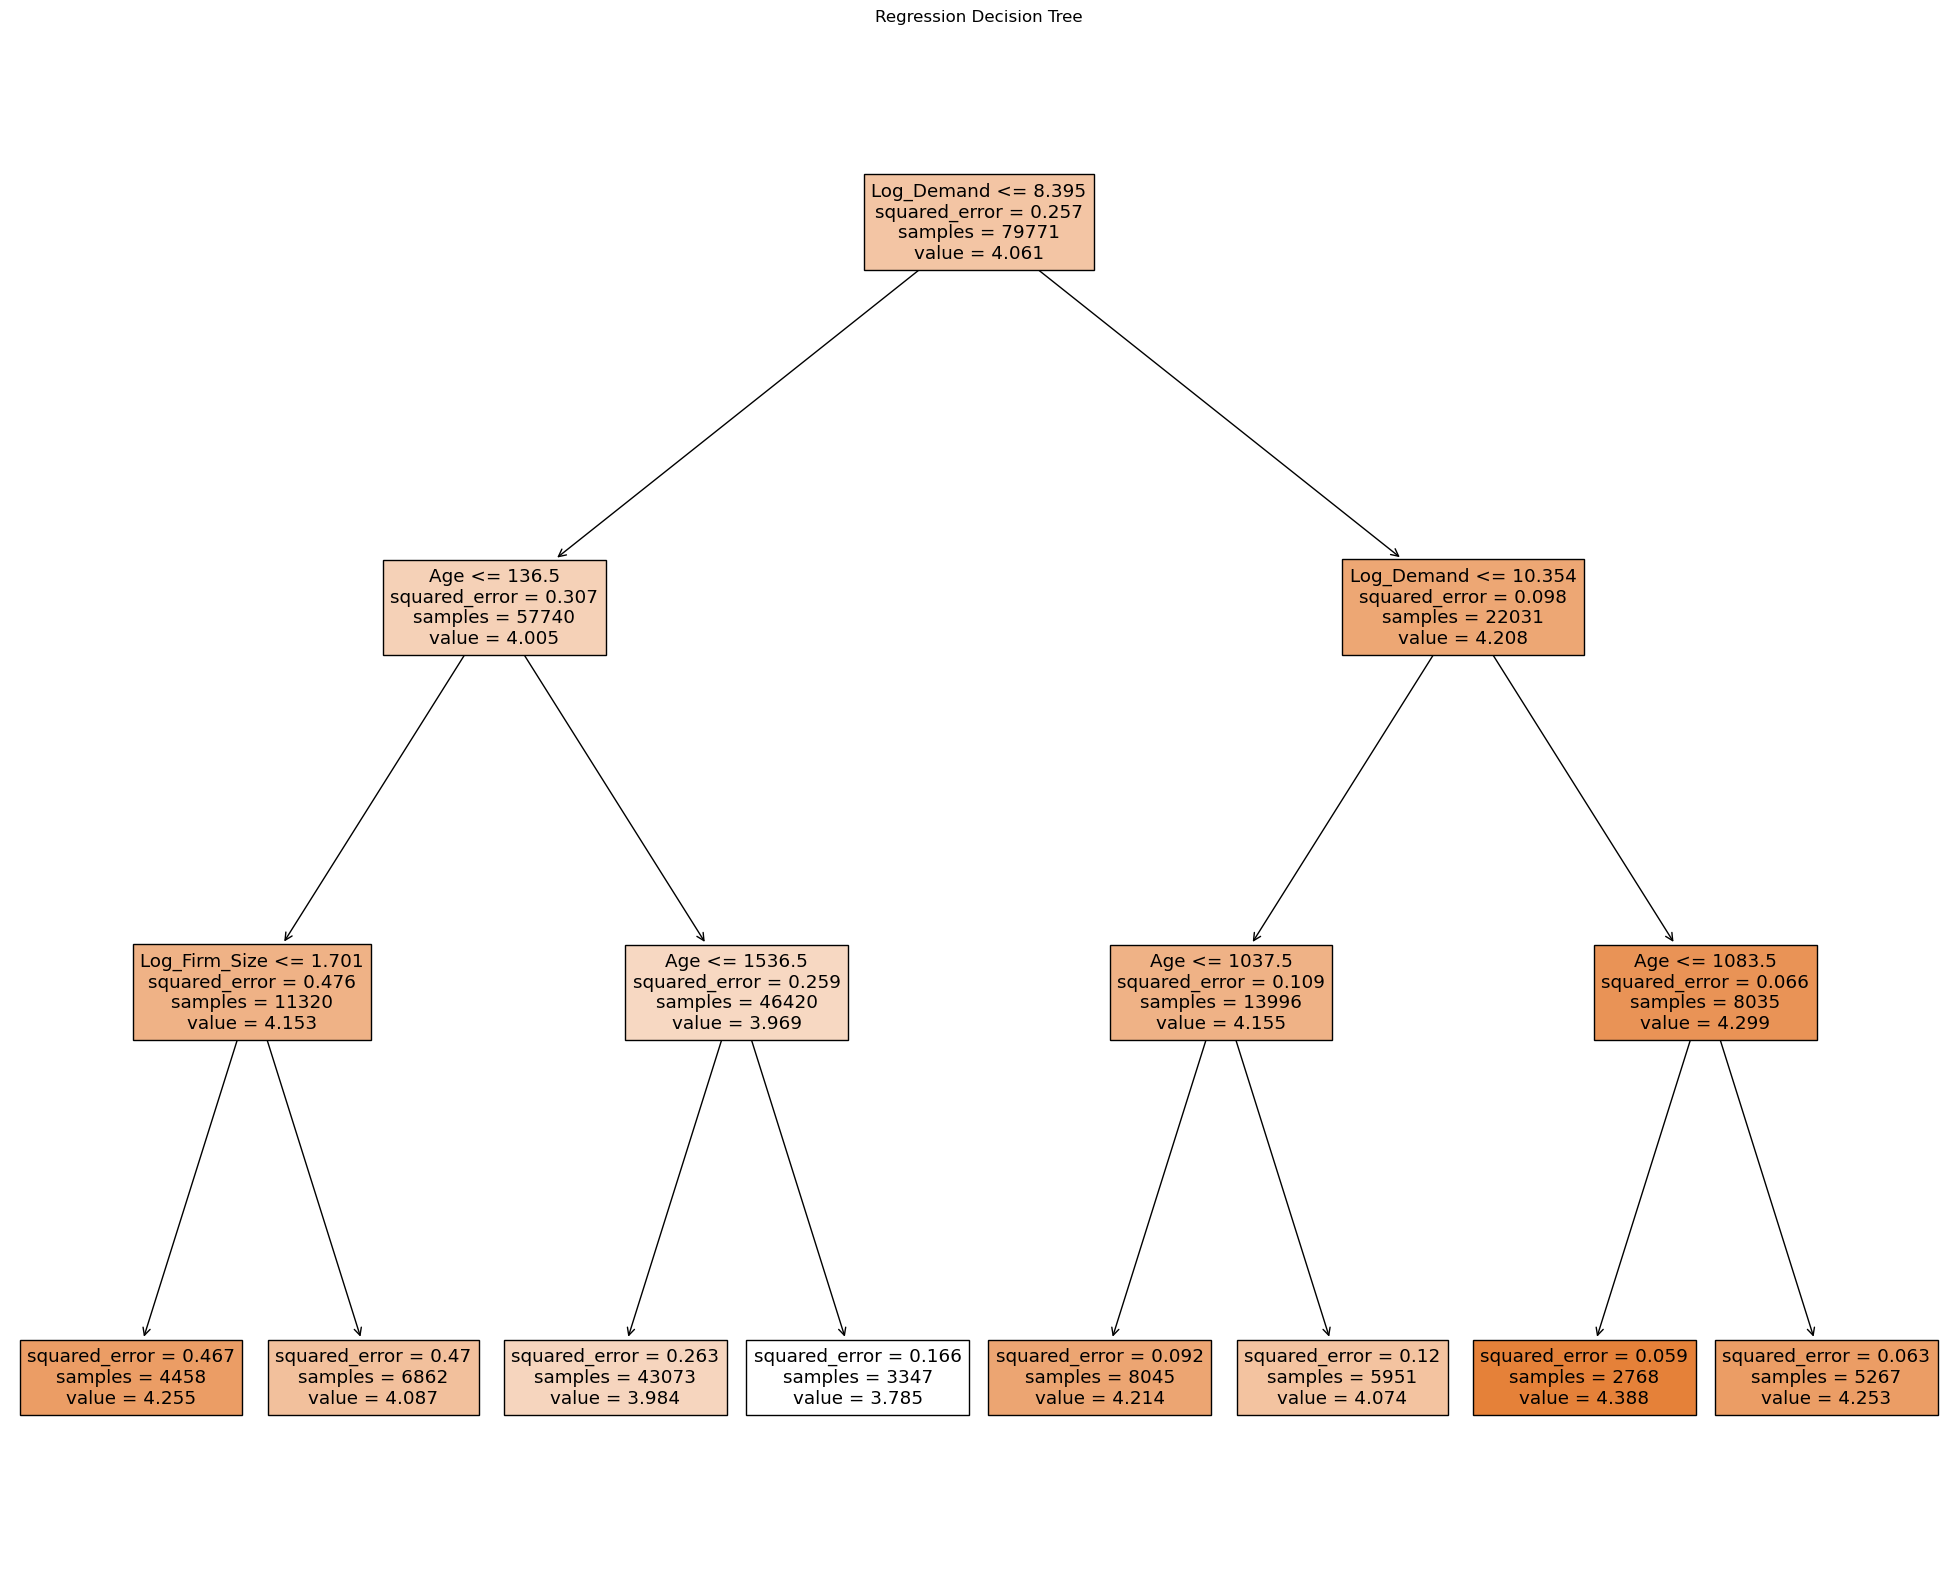

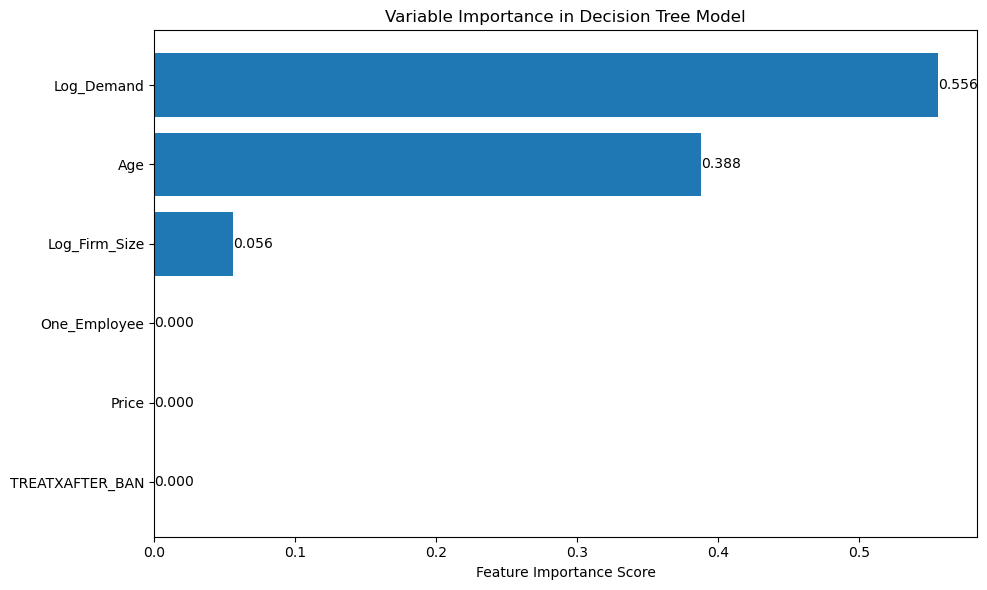


Feature Importance:
           feature  importance
0  TREATXAFTER_BAN    0.000000
2            Price    0.000000
4     One_Employee    0.000000
3    Log_Firm_Size    0.055799
5              Age    0.388201
1       Log_Demand    0.556000


In [23]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data():
    """Prepare data for regression and tree analysis"""
    filepath = r'at.dta'
    df = pd.read_stata(filepath)
    df = df.set_index(['app_num', 'ym'])
    df['AFTER_BAN'] = (df.index.get_level_values('ym') >= 716).astype(int)
    df['TREATXAFTER_BAN'] = df['ann_TREAT'] * df['AFTER_BAN']
    return df

def prepare_tree_data(df):
    """Prepare features for decision tree analysis"""
    tree_df = df.reset_index()
    
    feature_columns = ['TREATXAFTER_BAN', 'Log_Demand', 
                      'Price', 'Log_Firm_Size', 'One_Employee', 'Age']
    
    X = tree_df[feature_columns].copy()
    y = tree_df['Rating']
    
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    
    for col in X.columns:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, feature_columns

def run_regression_tree(X_train, X_test, y_train, y_test, feature_names):
    """Run and evaluate regression tree"""
    sqft_tree = DecisionTreeRegressor(max_depth=3)
    sqft_tree.fit(X_train, y_train)
    
    y_pred_tree = sqft_tree.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_tree)
    print(f'Mean Squared Error: {mse}')
    
    plt.figure(figsize=(25,20))
    plot_tree(sqft_tree, feature_names=feature_names, filled=True)
    plt.title('Regression Decision Tree')
    plt.show()
    
    return sqft_tree

def analyze_tree_importance(tree_model, feature_names):
    """Analyze and plot feature importance from tree model"""
    importances = tree_model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    feature_importance = feature_importance.sort_values('importance', ascending=True)  # Sort ascending for better visualization
    
    # Create the importance plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Feature Importance Score')
    plt.title('Variable Importance in Decision Tree Model')
    
    # Add value labels on the bars
    for i, v in enumerate(feature_importance['importance']):
        plt.text(v, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Importance:")
    print(feature_importance)
    return feature_importance

def main():
    print("Preparing data...")
    df = prepare_data()
    X_train, X_test, y_train, y_test, feature_names = prepare_tree_data(df)
    
    print("\nRunning Regression Tree Analysis:")
    reg_tree = run_regression_tree(X_train, X_test, y_train, y_test, feature_names)
    reg_importance = analyze_tree_importance(reg_tree, feature_names)
    
    return df, reg_tree, reg_importance

if __name__ == "__main__":
    df, reg_tree, reg_importance = main()

In [124]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS
import statsmodels.api as sm
from tabulate import tabulate
import warnings

# Suppress warnings for better clarity
warnings.filterwarnings("ignore")

def run_panel_regressions(df):
    # Convert ym to datetime for panel data structure
    df = df.copy()
    
    # Filter condition (preban period)
    mask = (df['ym'] <= 712) & (df['ym'] > 706)
    df_filtered = df[mask].copy()
    
    # Create MultiIndex before creating dummies
    df_filtered = df_filtered.set_index(['app_num', 'ym'])
    
    # Store ann_TREAT before creating dummies
    ann_treat = df_filtered['ann_TREAT']
    
    # Create dummies for time fixed effects (drop first to avoid multicollinearity)
    time_dummies = pd.get_dummies(df_filtered.index.get_level_values('ym'), prefix='time', drop_first=True)
    time_dummies.index = df_filtered.index
    
    # Create genre dummies (drop first to avoid multicollinearity)
    genre_dummies = pd.get_dummies(df_filtered['genre_num'], prefix='genre', drop_first=True)

    # Create interaction terms for t-5 through t-1
    interact_dummies = pd.DataFrame(index=df_filtered.index)
    for i, col in enumerate(time_dummies.columns):
        interact_dummies[f'treat_t_minus_{5-i}'] = time_dummies[col] * ann_treat

    # Add treatment variable and create treat_df
    treat_df = pd.DataFrame({'ann_TREAT': ann_treat}, index=df_filtered.index)

    # Combine all exogenous variables
    exog_data = pd.concat([treat_df, time_dummies, genre_dummies, interact_dummies], axis=1)
    
    # Dependent variables with their model types
    dep_vars = {
        'Feature_Update': 'LPM',
        'Rating': 'OLS',
        'Log_Demand': 'OLS',
        'Price': 'LPM',
        'File_Size': 'OLS',
        'Permissions': 'OLS'
    }
    
    results = []
    
    for dep_var, model_type in dep_vars.items():
        # Run regression
        model = PanelOLS(
            df_filtered[dep_var],
            exog_data,
            entity_effects=True,
            time_effects=False,
            check_rank=False
        )
        
        reg_results = model.fit(cov_type='clustered', cluster_entity=True)
        
        # Store results
        coef_data = []
        se_data = []
        
        # Get treatment interaction coefficients and standard errors for t-5 through t-1
        for i in range(5, 0, -1):
            col = f'treat_t_minus_{i}'
            coef = reg_results.params[col]
            se = reg_results.std_errors[col]
            
            # Add stars based on p-value
            p_value = reg_results.pvalues[col]
            stars = ''
            if p_value < 0.001:
                stars = '***'
            elif p_value < 0.01:
                stars = '**'
            elif p_value < 0.05:
                stars = '*'
                
            coef_data.append(f"{coef:.3f}{stars}")
            se_data.append(f"({se:.3f})")
        
        results.append({
            'dep_var': dep_var,
            'model_type': model_type,
            'coefficients': coef_data,
            'std_errors': se_data,
            'n_obs': reg_results.nobs,
            'r2': reg_results.rsquared_within,
            'f_stat': reg_results.f_statistic.stat  # Add this line
        })

    # Create table
    table_data = []
    
    # Header rows
    header = [''] + [f'({i+1})\n{var}' for i, var in enumerate(dep_vars.keys())]
    model_row = ['Estimator'] + [model_type for model_type in dep_vars.values()]
    table_data.append(model_row)
    
    # Coefficient rows
    time_labels = ['Treat × t-5', 'Treat × t-4', 'Treat × t-3', 'Treat × t-2', 'Treat × t-1']
    for i, label in enumerate(time_labels):
        row_coef = [label]
        row_se = ['']
        
        for result in results:
            row_coef.append(result['coefficients'][i])
            row_se.append(result['std_errors'][i])
            
        table_data.append(row_coef)
        table_data.append(row_se)
    
    # Statistics rows
    stats = [
        ('Observations', lambda r: str(int(r['n_obs']))),
        ('Game fixed effects', lambda r: 'x'),
        ('Category fixed effects', lambda r: 'x'),
        ('Month fixed effects', lambda r: 'x'),
        ('Adjusted R²', lambda r: f"{r['r2']:.3f}"),
        ('F-statistic', lambda r: f"{r['f_stat']:.2f}")  # Add F-stat back
    ]
    
    for stat_name, stat_func in stats:
        row = [stat_name]
        row.extend([stat_func(r) for r in results])
        table_data.append(row)
    
    # Create table with proper formatting
    table = tabulate(table_data, headers=header, tablefmt='pipe', stralign='right')
    
    # Add notes
    notes = [
        "Notes: Standard errors in parentheses",
        "*, **, *** indicate significance at the 5%, 1%, and 0.1% levels, respectively."
    ]
    
    return table + '\n\n' + '\n'.join(notes)

def main():
    filepath = 'at.dta'
    df = pd.read_stata(filepath)
    print("\nTable 9: Test for the Parallel Trends Assumption\n")
    table = run_panel_regressions(df)
    print(table)

if __name__ == "__main__":
    main()


Table 9: Test for the Parallel Trends Assumption

|                        |              (1) |      (2) |          (3) |     (4) |         (5) |           (6) |
|                        |   Feature_Update |   Rating |   Log_Demand |   Price |   File_Size |   Permissions |
|-----------------------:|-----------------:|---------:|-------------:|--------:|------------:|--------------:|
|              Estimator |              LPM |      OLS |          OLS |     LPM |         OLS |           OLS |
|            Treat × t-5 |            0.007 |   -0.010 |       -0.000 |  -0.000 |       0.067 |        -0.029 |
|                        |          (0.008) |  (0.007) |      (0.017) | (0.001) |     (0.084) |       (0.021) |
|            Treat × t-4 |           -0.003 |    0.002 |        0.003 |  -0.000 |       0.116 |        -0.009 |
|                        |          (0.008) |  (0.007) |      (0.019) | (0.001) |     (0.118) |       (0.026) |
|            Treat × t-3 |           -0.003 |   -0.00